In [1]:
import sys
import GPy
import logging
import numpy as np
import matplotlib.pyplot as plt

sys.path.append("/home/st/st_st/st_st163811/workspace/vle_using_solvation_free_energy")

from GPyOpt.methods import BayesianOptimization

from scipy.interpolate import interp1d
from tools.gaussian_process import GPR
from tools.reader import get_dh_dl, get_data

from utils_automated import get_new_lambdas, train_gpr, get_partial_uncertanty, get_rmsd, estimate_variance

logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

Warning on use of the timeseries module: If the inherent timescales of the system are long compared to those being analyzed, this statistical inefficiency may be an underestimate.  The estimate presumes the use of many statistically independent samples.  Tests should be performed to assess whether this condition is satisfied.   Be cautious in the interpretation of the data.


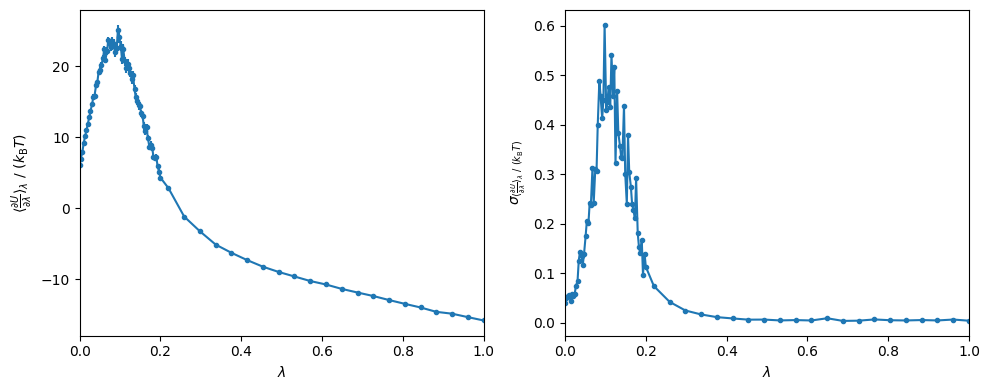

In [2]:
# Gather simulation results

data_output = "./lammps/hexane_hexane/reference_sim/sim_%d/fep%d%d.sampling"

idx_sim_folder = np.arange(0,81,1)
paths     = [data_output%(i,i,i+1) for i in idx_sim_folder]
lambdas   = np.round( np.concatenate( (np.linspace(0,0.2,60), np.linspace(0.22,1.0,21)) ), 3 )
mean, var = get_dh_dl( fe_data = [get_data(paths)], no_intermediates = len(lambdas), delta = 0.0001 , both_ways = False)


# Create subplots with 1 row and 2 columns
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))

# Plot the first figure on the left subplot
ax1.errorbar(lambdas,mean, yerr=np.sqrt(var), marker=".")
ax1.set_xlim(0,1)
ax1.set_xlabel("$\lambda$")
ax1.set_ylabel("$ \\langle \\frac{\partial U}{\partial \lambda} \\rangle_{\lambda} \ / \ (k_\mathrm{B}T)$")

# Plot the second figure on the right subplot
ax2.plot(lambdas, var, marker=".")
ax2.set_xlim(0,1)
ax2.set_xlabel("$\lambda$")
ax2.set_ylabel("$ \sigma_{ \\langle \\frac{\partial U}{\partial \lambda} \\rangle_{\lambda} \ / \ (k_\mathrm{B}T) }$")

# Adjust layout to prevent overlapping
plt.tight_layout()

# Show the plots
plt.show()
plt.close()

y_int = interp1d( lambdas, mean )
v_int = interp1d( lambdas, var )

# Utilize Bayessian Optimization

## Iterativly add lambdas

In [20]:
l_learn   = np.array([[]])
var_learn = np.array([[]])


lambda_init = [0.0, 0.4, 1.0]
var_init     = v_int(lambda_init)

for i in range(10):
    
    print(f"\nItteration n°{i}\n")

    # get partial uncertanties
    dG_i_inter  = get_partial_uncertanty( lambda_init, var_init )

    print(dG_i_inter)

    # Get rmsd to optimal variance
    rmsd        = get_rmsd(dG_i_inter,verbose=True)

    if l_learn.size == 0:
        l_learn   = np.array(lambda_init).reshape(-1, 1)
        var_learn = np.array(var_init).reshape(-1, 1)
    else:
        l_learn   = np.concatenate( [ l_learn, np.array(lambda_init).reshape(-1, 1) ] )
        var_learn = np.concatenate( [ var_learn, np.array(var_init).reshape(-1, 1) ] )

    # Sort training data and make it unique
    _ ,idx       = np.unique( l_learn, return_index=True )
    l_learn      = l_learn[idx]
    var_learn    = var_learn[idx]

    gpr_modeling = train_gpr(l_learn, var_learn, kernel = GPy.kern.Matern32 )

    lambda_init = get_new_lambdas(lambdas = lambda_init, variances = var_init, gpr_model = gpr_modeling, method = "GPR",
                                optimization_method ='bayesian_optimization', precision=3, verbose=False)
    var_init    = v_int(lambda_init)

    print("\n",lambda_init,"\n")
    print("\n",var_init,"\n")

    
    

## Multi dimensional optimization of all lambdas at once

In [9]:
precision = 2
std_dG_opt = 0.02

gpr_modeling = train_gpr( lambdas, var, kernel = GPy.kern.Matern32 )

# Define your objective function
def objective_function(x):
    
    x = np.concatenate( [ np.zeros(1), x.flatten(), np.ones(1) ] )

    if np.unique( np.round( x, precision ) ).size < 10:
        #print("not unique",x)
        rmsd = 1e6
    else:
        x = np.unique( np.round( x, precision ) )

        var_init = [ abs( gpr_modeling.predict([[xx]])[0].item() ) for xx in x ]
        
        std_dG_i = get_partial_uncertanty( x, var_init )

        # Relative root mean square deviation of the current iteration lambdas to the optimal value 
        # (which is computed as the mean of the input data and the number of newly intermediates)
        rmsd     = np.sqrt( np.mean( (np.array(std_dG_i) - std_dG_opt)**2 ) ) / std_dG_opt
    
    return rmsd

# Define the bounds of the input space
domain = [{'name': f'var_{i}', 'type': 'continuous', 'domain': (0.01, 0.99)} for i in range(8)]

# Create the Bayesian Optimization object
bayesian_optimizer = BayesianOptimization(f=objective_function, domain=domain, model_type='GP')

# Run the optimization loop
max_iter = 5
bayesian_optimizer.run_optimization(max_iter)

# Get the optimized point and value
best_point = np.round( np.concatenate( [ np.zeros(1), bayesian_optimizer.x_opt.flatten(), np.ones(1) ] ), precision )
best_value = np.round( bayesian_optimizer.fx_opt * 100 )

print("Best point:", best_point)
print("Best value:", best_value)

INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


Optimization restart 1/3, f = -135.04376420795677
Optimization restart 2/3, f = -63.041169574655214
Optimization restart 3/3, f = -135.04376420762878


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


Best point: [0.   0.96 0.82 0.3  0.92 0.15 0.79 0.84 0.63 1.  ]
Best value: 108.0


# Utilize numerical gradien free methods

In [ ]:
l_learn   = np.array([[]])
var_learn = np.array([[]])


lambda_init = [0.0, 0.4, 1.0]
var_init     = v_int(lambda_init)

for i in range(10):

    print(f"\nItteration n°{i}\n")

    # get partial uncertanties
    dG_i_inter  = get_partial_uncertanty( lambda_init, var_init )

    print(dG_i_inter)

    # Get rmsd to optimal variance
    rmsd        = get_rmsd(dG_i_inter,verbose=True)

    if l_learn.size == 0:
        l_learn   = np.array(lambda_init).reshape(-1, 1)
        var_learn = np.array(var_init).reshape(-1, 1)
    else:
        l_learn   = np.concatenate( [ l_learn, np.array(lambda_init).reshape(-1, 1) ] )
        var_learn = np.concatenate( [ var_learn, np.array(var_init).reshape(-1, 1) ] )

    # Sort training data and make it unique
    _ ,idx       = np.unique( l_learn, return_index=True )
    l_learn      = l_learn[idx]
    var_learn    = var_learn[idx]

    gpr_modeling = train_gpr(l_learn, var_learn, kernel = GPy.kern.Matern32 )

    lambda_init = get_new_lambdas(lambdas = lambda_init, variances = var_init, gpr_model = gpr_modeling, method = "GPR",
                                  optimization_method ='nelder_mead', precision=3, verbose=True)
    var_init    = v_int(lambda_init)

    print("\n",lambda_init,"\n")
    print("\n",var_init,"\n")

    
print("\n",lambda_init,"\n")
print("\n",var_init,"\n")

dG_i_inter  = get_partial_uncertanty( lambda_init, var_init )

print(dG_i_inter)

# Get rmsd to optimal variance
rmsd        = get_rmsd(dG_i_inter,verbose=True)

# Utilize linear interpolation

In [7]:
lambda_init = [0.0, 0.4, 1.0]
var_init     = v_int(lambda_init)

for i in range(7):

    print(f"\nItteration n°{i}\n")

    # get partial uncertanties
    dG_i_inter  = get_partial_uncertanty( lambda_init, var_init )

    print(dG_i_inter)

    # Get rmsd to optimal variance
    rmsd        = get_rmsd(dG_i_inter,verbose=True)

    lambda_init = get_new_lambdas(lambdas = lambda_init, variances = var_init, method = "linear_adapt",
                                  precision=3, verbose=True)
    var_init    = v_int(lambda_init)

    print("\n",lambda_init,"\n")
    print("\n",var_init,"\n")

    
print("\n",lambda_init,"\n")
print("\n",var_init,"\n")

dG_i_inter  = get_partial_uncertanty( lambda_init, var_init )

print(dG_i_inter)

# Get rmsd to optimal variance
rmsd        = get_rmsd(dG_i_inter,verbose=True) 


Itteration n°0

[0.04264472316567883, 0.04591261157367181]

Optimal uncertanty in each lambda step: 0.044

Relative RMSD to optimal value: 3.69%


 [0.0, 0.276, 0.613, 1.0] 


 [0.03972961 0.03461354 0.00496596 0.00413165] 


Itteration n°1

[0.04004719617935891, 0.0387537029389661, 0.023415825529393534]

Optimal uncertanty in each lambda step: 0.034

Relative RMSD to optimal value: 22.17%


 [0.0, 0.176, 0.371, 0.591, 1.0] 


 [0.03972961 0.29178096 0.01205684 0.00500164 0.00413165] 


Itteration n°2

[0.062279255683711746, 0.06049753299367698, 0.021050901558797894, 0.03299646852570206]

Optimal uncertanty in each lambda step: 0.044

Relative RMSD to optimal value: 40.05%


 [0.0, 0.1, 0.203, 0.318, 0.568, 1.0] 


 [0.03972961 0.51628679 0.10734518 0.02067352 0.00534966 0.00413165] 


Itteration n°3

[0.04726973489321862, 0.045036688258008314, 0.025997517988959416, 0.03981853732344597, 0.04709583580296013]

Optimal uncertanty in each lambda step: 0.041

Relative RMSD to optimal value